# Supervisor - Worker Flow for Gen Pod AI Backend

Let us import some basic libraries and load dotenv file, make sure it contains necessary API keys.

In [1]:
import os
import pprint as pp
from dotenv import load_dotenv

load_dotenv()

True

## Loading LLM
We will load OpenAI GPT-4o LLM to assist our agents.

In [3]:
from langchain_openai import ChatOpenAI
# gpt-4o-2024-05-13

llm = ChatOpenAI(model="gpt-4o-2024-05-13", temperature=0, max_retries=5, seed=4000)
code_llm = ChatOpenAI(model="gpt-4-turbo-2024-04-09",temperature=0.3, max_retries=5, seed=4000)

c:\Users\vkumar\OneDrive - Imagevision.ai India Pvt Ltd\Documents\Projects\Compage-Agents\.venv\Lib\site-packages\langchain_core\utils\utils.py:161: UserWarning: WARNING! seed is not default parameter.
                seed was transferred to model_kwargs.
                Please confirm that seed is what you intended.
  warnings.warn(
c:\Users\vkumar\OneDrive - Imagevision.ai India Pvt Ltd\Documents\Projects\Compage-Agents\.venv\Lib\site-packages\langchain_core\utils\utils.py:161: UserWarning: WARNING! seed is not default parameter.
                seed was transferred to model_kwargs.
                Please confirm that seed is what you intended.
  warnings.warn(


In [4]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.output_parsers import JsonOutputParser
from langchain.schema import Document
from typing_extensions import TypedDict
from typing import List
# from langgraph.prebuilt import ToolExecutor, ToolInvocation
import json
# from langchain_core.agents import AgentAction, AgentFinish

## Let us create some Utility function
These function can help later on to read the input files as a json string and create agents that can be later used as nodes in the graph.

In [23]:
def read_input_json(file_path) -> str:
    """Reads JSON data from a file and returns it as a string.

    Args:
        file_path: The path to the JSON file.

    Returns:
        A string representation of the JSON data.
    """
    # with open(file_path, 'r') as user_input_file:
    #     data = json.load(user_input_file)
    
    # user_input = json.dumps(data)
    # license_txt = data["LICENSE_TEXT"]

    # return user_input, license_txt
    with open(file_path, 'r') as user_input_file:
        data = json.load(user_input_file)
    
    if 'prompt' in data:
        additional_input = data['prompt']
        del data['prompt']
        data['additional_input'] = additional_input
    
    userinput = json.dumps(data)
    license_txt = data["LICENSE_TEXT"]

    return userinput, license_txt

In [6]:
# To dynamically create any number of agents
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.messages import (
    BaseMessage,
    ToolMessage,
    HumanMessage,
)
# from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import END, StateGraph
from langchain import agents
from langchain_community.vectorstores import Chroma
from langchain_community.embeddings import GPT4AllEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.memory import ConversationBufferMemory

def create_agent(llm, tools, system_message: str):
    """Create an agent."""
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                " You are a helpful AI assistant, collaborating with other assistants."
                " Use the provided tools to progress towards completing the task."
                " Execute what you can to make progress."
                " If you or any of the other assistants have the final answer or deliverable,"
                " prefix your response with FINAL ANSWER so the team knows to stop."
                " You have access to the following tools: {tool_names}.\n{system_message}",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    prompt = prompt.partial(system_message=system_message)
    if not tools:
        prompt = prompt.partial(tool_names="")
        return prompt | llm
    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
    # llm = llm.bind_tools(tools=tools)
    
    return prompt | llm.bind_tools(tools)

## Define tools to be used by Agents
These tools are custom fuctions that will also go as nodes in the graph and will be called by the agent to take some action.

In [7]:
# Update this path to your local directory where you want to create the project at.
PROJECT_PATH = "C:/Users/vkumar/Desktop"

In [8]:
from langchain_core.tools import tool, StructuredTool
from typing import Annotated
import os
from langchain.pydantic_v1 import BaseModel, Field
from langchain.tools import BaseTool, StructuredTool, tool


@tool
def write_generated_code_to_file(
    generated_code: Annotated[str, "The code generated by the agent."],
    file_path: Annotated[str, "Absolute path where the generated code should be written can handle directory create if does not exist."]
    # license_txt: Annotated[str, "License txt provided by user to add to each src file."]
):
# project_folder: Annotated[str, "The name of the project where all files needed for the project are to placed."]
    """
    Writes the provided generated code to the specified file within the project structure.

    Args:
        generated_code (str): The code generated by the agent.
        file_path (str): The path where the generated code should be written.
    """
    try:

        # Ensure the directory exists before writing the file
        os.makedirs(os.path.dirname(file_path), exist_ok=True)
        
        with open(file_path, 'w') as file:
            file.write(generated_code)
        
        return {'project_files':file_path}, f"Successfully wrote the generated code to: {file_path}"
    except BaseException as e:
        return f"Failed to write generated code. Error: {repr(e)}"
    

In [9]:
import os
import subprocess
from typing import Annotated
from langchain.tools import tool

@tool
def create_git_repo(project_name: Annotated[str, "Name of the new Git repository that should be created."], repo_path: str) -> dict:
    """
    Creates a new Git repository at the specified path.

    Args:
        project_name (str): Name of the new Git repository that should be created.
        PROJECT_PATH (str): Path where the new Git repository will be created.

    Returns:
        A dictionary containing the path of the newly created Git repository or an error message.
    """
    try:
        repo_path = os.path.join(PROJECT_PATH, project_name)
        
        # Ensure the directory exists before initializing the Git repository
        os.makedirs(repo_path, exist_ok=True)
        
        # check_path = os.path.join(repo_path, ".git")
        # Check if the directory is already a Git repository
        # if os.path.exists(check_path):
        #     return f"Project is already a git repository: {repr(e)}"
        
        subprocess.check_output(['git', 'init'], cwd=repo_path)
        
        return {'repo_path': repo_path}, f"Git repository created successfully: {repo_path}"
    except Exception as e:
        return f"Failed to create a new Git repository. Error: {repr(e)}"


In [10]:
import subprocess
from typing import Annotated
from langchain.tools import tool

ALLOWED_COMMANDS = ['mkdir', 'docker', 'python', 'python3', 'pip', 'virtualenv', 'mv', 'pytest']

@tool
def execute_command(
    command: Annotated[str, "The complete set of commands to be executed on the local machine in order."],
    repo_path: Annotated[str,"Path where the repository is created."]
):
    """
    Executes a command on the local machine.

    Args:
        command (str): The complete set of commands to be executed on the local machine in order.
    """
    # Split the command into parts
    parts = command.split()
    
    # Check if the command is in the whitelist
    if parts[0] not in ALLOWED_COMMANDS:
        return f"Command '{parts[0]}' is not allowed."
    
    try:
        # Execute the command
        # full_path = os.path.join(PROJECT_PATH,repo_path)
        additional_command = f"cd {repo_path} && "
        updated_command = additional_command + command
        result = subprocess.check_output(updated_command, shell=True)
        
        return f"Command executed successfully. Output: {result}"
    except BaseException as e:
        return f"Failed to execute command. Error: {repr(e)}"


In [11]:
import os
from typing import Annotated, List
from langchain.tools import tool

@tool
def check_files_created(
    files: Annotated[List[str], "The list of files that should be present in the project repository."],
    repo_path: Annotated[str, "Absolute Path where the repository is created."]
):
    """
    Checks if all the specified files within a folder structure are created or not.

    Args:
        files (List[str]): The list of files to check.
    """
    missing_files = []
    
    # Check each file
    for file in files:
        full_file_path = os.path.join(repo_path, file)
        
        # Directly check if the file exists without executing shell commands
        if not os.path.exists(full_file_path):
            missing_files.append(file)
    
    if missing_files:
        return {"missing_files":missing_files}, f"missing these files: {missing_files}"
    else:
        return "All files are present."

In [12]:
import os
from typing import Annotated, List
from langchain.tools import tool

@tool
def verify_file_content(
    files: Annotated[List[str], "The list of files that should be present in the project repository."],
    repo_path: Annotated[str, "Absolute Path where the repository is created."]
):
    """
    Checks if all the specified files within a folder structure are empty or not.

    Args:
        files (List[str]): The list of files to check.
    """
    empty_files = []
    
    # Check each file
    for file in files:
        full_file_path = os.path.join(repo_path, file)
        
        # Check if the file exists and is empty
        if os.path.exists(full_file_path) and os.path.getsize(full_file_path) == 0:
            empty_files.append(file)
    
    if empty_files:
        return f"These files are empty: {empty_files}"
    else:
        return "All files are not empty."

In [13]:
import requests
import os
from typing import Annotated

@tool
def download_license_file(
        url: Annotated[str, "LICENSE_URL from where it has to be downloaded."],
        file_path: Annotated[str, "Absolute path where the License.md should be written can handle directory create if does not exist."]
 ) -> str:
    """
    Downloads a license file from a given URL and saves it locally.

    Args:
    url (str): The URL of the license file.
    file_path (str): Absolute path where the generated code should be written can handle directory create if does not exist.
    
    Returns:
    str: The local path where the file was saved.
    """
    import pprint as pp
    response = requests.get(url)
    # print(response.content)
    # response.raise_for_status()  # Raise exception if the request failed
    try:
        os.makedirs(os.path.dirname(file_path), exist_ok=True)

        with open(file_path, 'wb') as file:
            file.write(response.content)
        return f"Successfully wrote the License to {file_path}"

    except:
        return f"failed to write the License to {file_path}"


## Define State
We first define the state of the graph. This will just be a list of messages, along with a key called 'sender' to track the most recent sender.

In [14]:
import operator
from typing import Annotated, Sequence, TypedDict

from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict


# This defines the object that is passed between each node
# in the graph. We will create different nodes for each agent and tool
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: str
    project_files: Annotated[List[str], "List of Project file paths created that needs to be reviewed."]
    license_url: Annotated[str, "URL where the license is located to be downloaded."]
    license_text: Annotated[str, "Text provided by user that must be prefixed to everything the coder generates."]
    missing_files: Annotated[List[str], "List of files that are missing from the Project folder."]


## Define Agent Nodes
Using the create_agent utility function let us create different agents that can then be created as a node in the graph.

In [15]:
import functools
from langchain_core.messages import AIMessage
from langchain.agents import AgentType


# Helper function to create a node for a given agent
def agent_node(state, agent, name):
    result = agent.invoke(state)
    # print(f"result after calling the llm chain: {result}")
    # We convert the agent output into a format that is suitable to append to the global state
    if isinstance(result, ToolMessage):
        pass
    else:
        result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)
    return {
        "messages": [result],
        # Since we have a strict workflow, we can
        # track the sender so we know who to pass to next.
        "sender": name,
    }

# architect agent and node
Solution_Architect = create_agent(
    llm,
    [],
    system_message= "You are a Development Lead in charge of implementing the given project. Thoroughly analyze the user provided requirements, and build a thorough requirements document."
                    "Collaborate with the Coder by providing this enhanced detailed Requirements Document and assigning tasks sequentially while providing additional clarification if requested by coder." 
                    "As for your expertise, enforce Coder to use microservice architecture, Best practices Project Folder structure, 12-factor application standards," 
                    "domain-driven microservice application design, clean-code development architecture standards," 
                    "Instruct Coder to insert the licensing text provided by the user into each file they create"
                    "Final project should include all the source files, configuration files, unit test files, YAML OpenAPI specfile for the project, License.md file from the User provided URL, a Requirements.txt file, Dockerfile, gitignore and a dockerignore file."
                    "Finish only after verifying completion of the Project.",
)
architect_node = functools.partial(agent_node, agent=Solution_Architect, name="Architect")

coder_agent = create_agent(
    code_llm,
    [execute_command, write_generated_code_to_file, download_license_file, create_git_repo, check_files_created],
    system_message=f"You are an expert Programmer, who does not assume anything and asks Architect for additional context and clarification if requirements are not clear." 
                    "you know how to follow secure production standards," 
                    "writes well commented, modularized and complete code following standards," 
                    "Create good project folder structure," 
                    "should write the files to the local filesystem."
                    "Follow microservices development standards like 12-factor application standards, domain-driven microservice application and clean-code development architecture standards as well.",
                    # "finish by check you have created all the files.",
                    # "For every function you are generating add an inline comment as FUNCTION STARTED and then generate the function, after that add an in-line comment as FUNCTION ENDED."
    # system_message="You are an expert Programmer, Follow secure production standards, write well modularized and complete code following standards, Create good project folder structure, write the files to the local filesystem",
)
coder_node = functools.partial(agent_node, agent=coder_agent, name="Coder")

## Define a Tool Node
Next we need to define a node in the graph to run the custom tools that we created earlier.

In [17]:
from langgraph.prebuilt import ToolNode

coder_tools = [execute_command, write_generated_code_to_file, download_license_file, create_git_repo, check_files_created]
# architect_tools = [check_files_created, create_git_repo]
coder_tool_node = ToolNode(coder_tools)
# architect_tool_node = ToolNode(architect_tools)

## Define Edges
We need to define some logic on what to do next after the agent has its results ready.

In [18]:
# Either agent can decide to end
from typing import Literal


def router(state) -> Literal["call_tool", "__end__", "continue"]:
    # This is the router
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        # The previous agent is invoking a tool
        return "call_tool"
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return "__end__"
    return "continue"

## Need for Persistence
In LangGraph, memory for maintaining context across interactions is facilitated via Checkpointers within StateGraphs.  
1. When setting up a LangGraph workflow, you can ensure state persistence by employing a Checkpointer like `AsyncSqliteSaver`.  
2. Simply include this in your workflow setup by calling `compile(checkpointer=my_checkpointer)` during graph compilation.

In [19]:
from langgraph.checkpoint.sqlite import SqliteSaver

memory = SqliteSaver.from_conn_string(":memory:")

## Define the Graph
Let's put all the agent nodes, tool nodes and edge logic defined earlier together to build the workflow. We will also make use of the memory here.

In [20]:
workflow = StateGraph(AgentState)

workflow.add_node("Architect", architect_node)
workflow.add_node("Coder", coder_node)
workflow.add_node("call_coder_tool", coder_tool_node)
# workflow.add_node('call_architect_tool', architect_tool_node)

workflow.add_conditional_edges(
    "Architect",
    router,
    {"continue": "Coder", "__end__": END},
    # {"continue": "Coder", "call_tool": "call_tool", "__end__": END},
)
workflow.add_conditional_edges(
    "Coder",
    router,
    {"continue": "Architect", "call_tool": "call_coder_tool", "__end__": END},
)

workflow.add_conditional_edges(
    "call_coder_tool",
    # Each agent node updates the 'sender' field
    # the tool calling node does not, meaning
    # this edge will route back to the original agent
    # who invoked the tool
    lambda x: x["sender"],
    {
        "Architect": "Architect",
        "Coder": "Coder",
    },
)
# workflow.add_conditional_edges(
#     "call_architect_tool",
#     # Each agent node updates the 'sender' field
#     # the tool calling node does not, meaning
#     # this edge will route back to the original agent
#     # who invoked the tool
#     lambda x: x["sender"],
#     {
#         "Architect": "Architect",
#         "Coder": "Coder",
#     },
# )
workflow.set_entry_point("Architect")

# Lets make sure we pass the memory that we defined earlier to the graph as we compile the workflow.
graph = workflow.compile(checkpointer=memory)

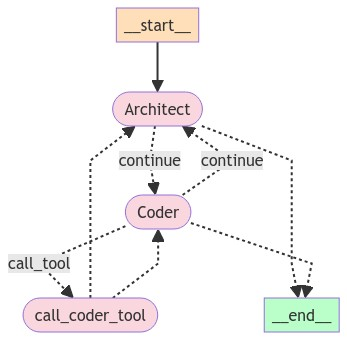

In [21]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except:
    # This requires some extra dependencies and is optional
    pass

## Invoke the graph
Now that we have a compiled graph with multiple agents and custom tools ready, we can invoke to graph to do a small task for us. 

In [24]:
import pprint as pp

# First lets read in the input that defines the task to be performed by the multi agent setup
user_input, license_text = read_input_json("rest_api.json")
pp.pp(user_input)

('{"name": "user-service", "language": "python", "restConfig": {"server": '
 '{"sqlDB": "MySQL", "port": "3000", "resources": [{"name": "User", '
 '"allowedMethods": ["POST", "LIST", "GET", "PUT", "DELETE"], "fields": '
 '{"Name": {"datatype": "string"}, "City": {"datatype": "string"}}}]}, '
 '"framework": "fastapi"}, "LICENSE_URL": '
 '"https://raw.githubusercontent.com/intelops/tarian-detector/8a4ff75fe31c4ffcef2db077e67a36a067f1437b/LICENSE", '
 '"LICENSE_TEXT": "This code base copyrights belong to XYZ", '
 '"additional_input": "Instrument the code you generate with latest version of '
 'opentelemetry sdk so that this REST API service can send data to '
 'opentelemetry collector agent for observability purposes."}')


In [25]:
import pprint as pp
events = graph.stream(
    {
        "messages": [
            HumanMessage(
                content=f"Create this project for me in {PROJECT_PATH}." 
                f"Requirements are {user_input}."
                f"{license_text} must be present at the top of each file created as part of the project." 
                "Once you code it up, finish."
            )
        ]
    },
    # Maximum number of steps to take in the graph and the thread ID to be used to persist the memory.
    {
        "recursion_limit": 150,
        "configurable": {"thread_id": "1"}
    },
    stream_mode='debug'
)
for s in events:
    pp.pp(s)
    print("----")

{'type': 'checkpoint',
 'timestamp': '2024-05-24T22:10:17.285073+00:00',
 'step': 0,
 'payload': {'config': {'configurable': {'thread_id': '1',
                                         'thread_ts': '2024-05-24T22:10:17.284081+00:00'}},
             'values': {'messages': [HumanMessage(content='Create this project for me in C:/Users/vkumar/Desktop.Requirements are {"name": "user-service", "language": "python", "restConfig": {"server": {"sqlDB": "MySQL", "port": "3000", "resources": [{"name": "User", "allowedMethods": ["POST", "LIST", "GET", "PUT", "DELETE"], "fields": {"Name": {"datatype": "string"}, "City": {"datatype": "string"}}}]}, "framework": "fastapi"}, "LICENSE_URL": "https://raw.githubusercontent.com/intelops/tarian-detector/8a4ff75fe31c4ffcef2db077e67a36a067f1437b/LICENSE", "LICENSE_TEXT": "This code base copyrights belong to XYZ", "additional_input": "Instrument the code you generate with latest version of opentelemetry sdk so that this REST API service can send data to opent